# GeoBench Burn Scars

In [1]:
import os
from pathlib import Path

import torch

from geobench_v2.datamodules import GeoBenchBurnScarsDataModule
from geobench_v2.datasets import GeoBenchBurnScars
from geobench_v2.datasets.normalization import SatMAENormalizer, ZScoreNormalizer
from geobench_v2.datasets.visualization_util import (
    compare_normalization_methods,
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
    visualize_segmentation_target_statistics,
)

%load_ext autoreload
%autoreload 2

In [3]:
PROJECT_ROOT = Path("../../")

STATS_SATMAE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_satmae", "burn_scars", "burn_scars_stats.json"
)
STATS_CLIP_RESCALE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_clip_rescale", "burn_scars", "burn_scars_stats.json"
)


In [5]:
band_order = GeoBenchBurnScars.band_default_order


datamodule = GeoBenchBurnScarsDataModule(
    img_size=256,
    batch_size=16,
    num_workers=4,
    root="/Users/paolofraccaro/Downloads/hls_burn_scars/",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


In [8]:
geotiff_path = '/Users/paolofraccaro/Downloads/hls_burn_scars/data/subsetted_512x512_HLS.S30.T10TGT.2018188.v1.4_merged.tif'

In [ ]:
import rasterio 
import pandas as pd
from pyproj import Proj, transform

with rasterio.open(geotiff_path) as src:
    profile = src.profile
    height, width = profile["height"], profile["width"]
    crs = "EPSG:32660"
    transform_ = profile["transform"].to_gdal() if profile["transform"] else None


In [12]:
old_coord_list = [(transform[0],transform[3])]

In [15]:
df_coords = pd.DataFrame(old_coord_list, columns=["x_old", "y_old"])

inProj, outProj = Proj(init="EPSG:32660"), Proj(init="EPSG:4326")



/Users/paolofraccaro/miniforge3/envs/geobenchv2/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/paolofraccaro/miniforge3/envs/geobenchv2/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
df_coords

,x_old,y_old
0,716760.0,5213190.0


In [25]:
df_coords["y_old"].tolist()

[5213190.0]

In [23]:
df_coords["x"], df_coords["y"] = transform(inProj, outProj, df_coords["x_old"].tolist(), df_coords["y_old"].tolist())




TypeError: 'tuple' object is not callable

In [ ]:
new_coord_list = df_coords[["x", "y"]].values.tolist()

In [6]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

ValueError: Metadata is missing required latitude and longitude information

## Dataset Statistics

Computed over the training dataset.

### Image Dataset Statistics

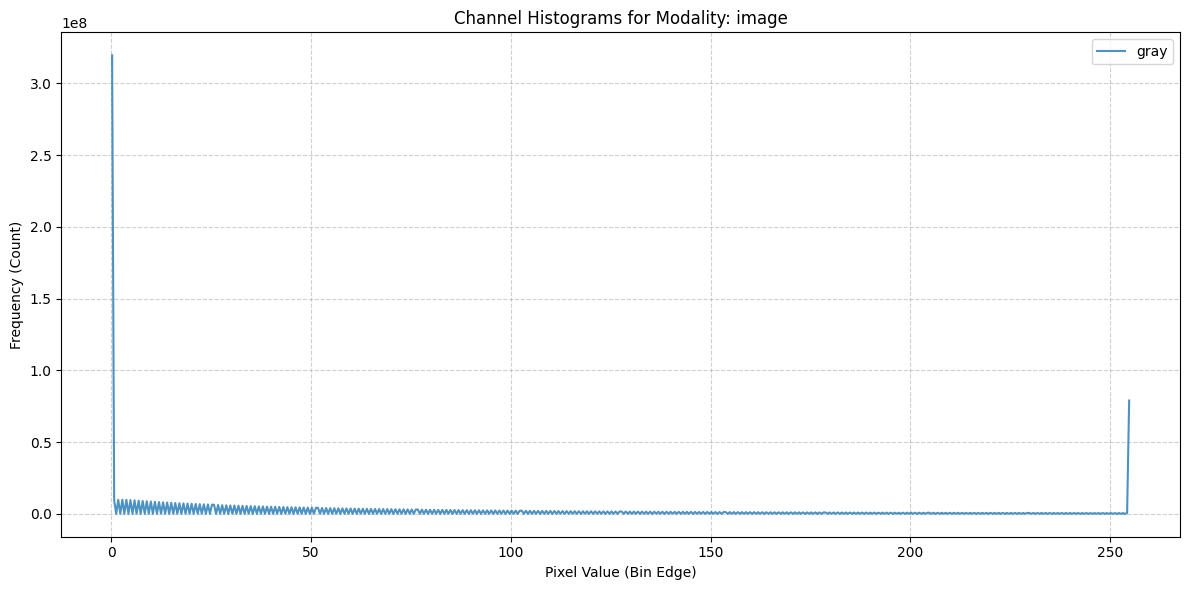

In [5]:
fig = plot_channel_histograms(STATS_SATMAE_PATH)

### Target Statistics

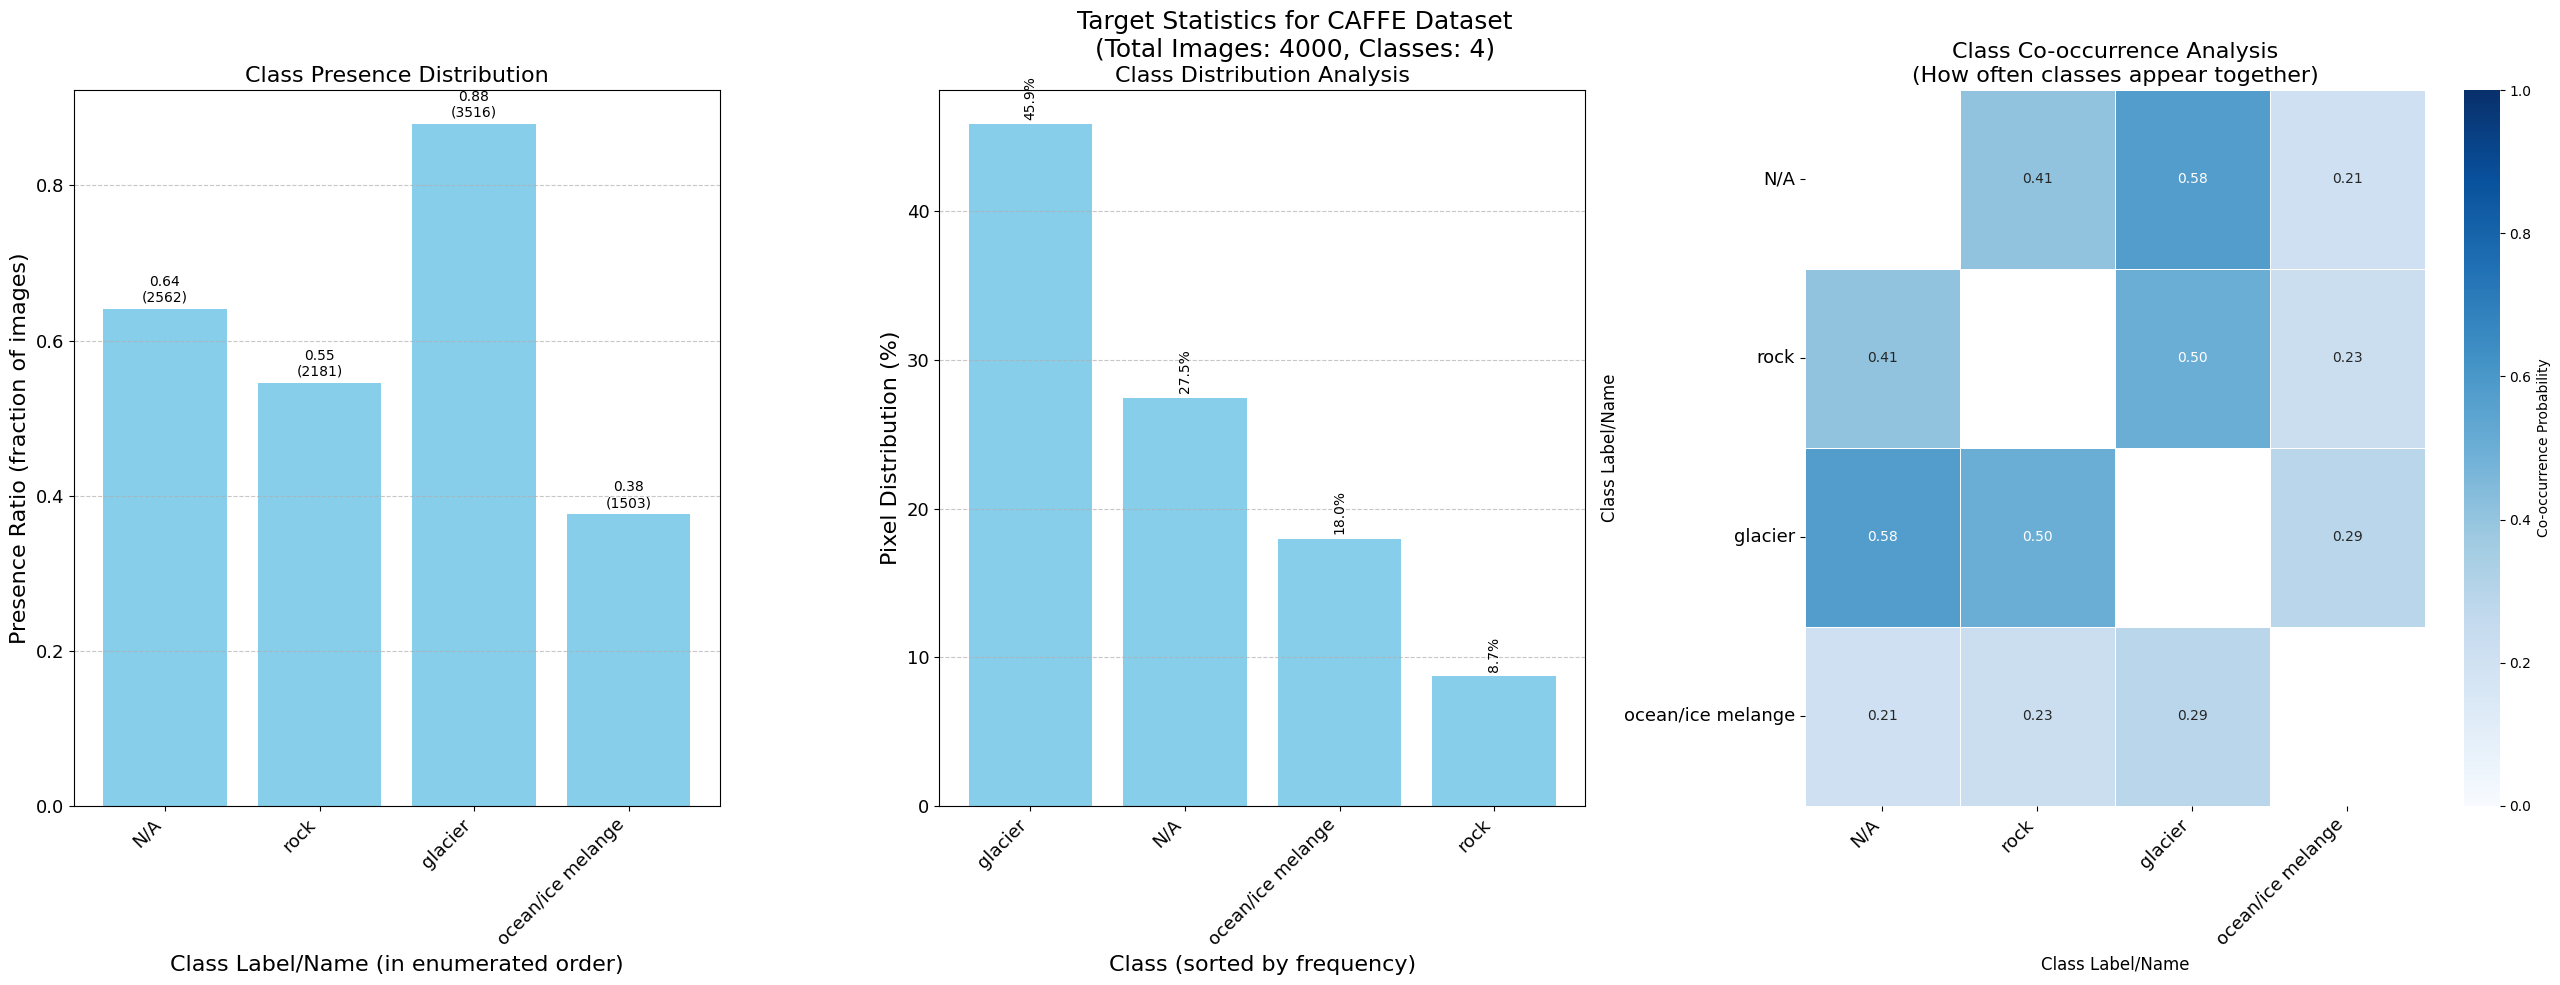

In [6]:
fig = visualize_segmentation_target_statistics(STATS_SATMAE_PATH,"CaFFe")

### Raw Batch Statistics

[<Figure size 1200x500 with 1 Axes>]

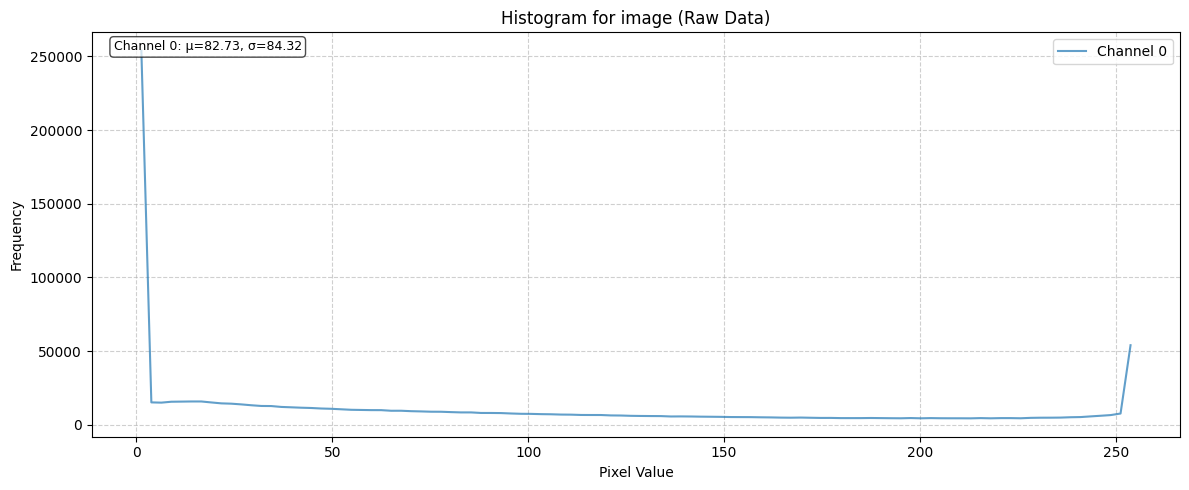

In [7]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)


raw_figs = plot_batch_histograms(
    raw_batch_stats, band_order, title_suffix=" (Raw Data)"
)
raw_figs

### Effect of different Normalization Schemes

In [13]:
zscore_normalizer = ZScoreNormalizer(STATS_CLIP_RESCALE_PATH, band_order)
satmae_normalizer = SatMAENormalizer(STATS_SATMAE_PATH, band_order)

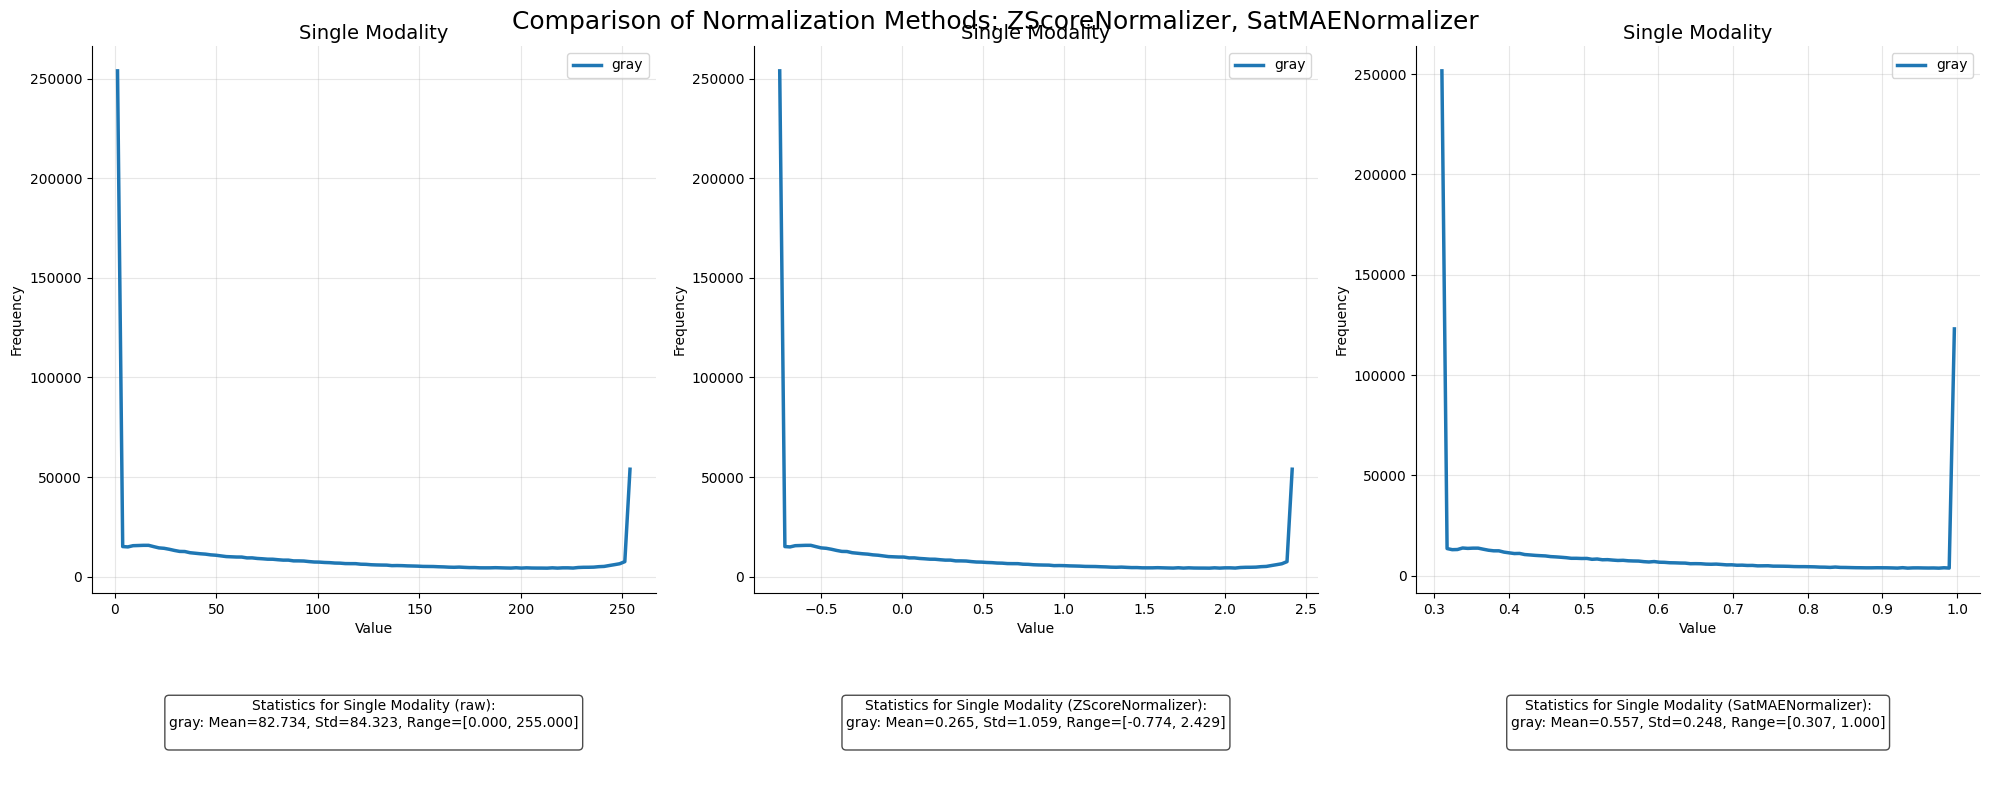

In [17]:
norm_fig, normalized_batches = compare_normalization_methods(
    raw_batch,
    [zscore_normalizer, satmae_normalizer],
    datamodule,
)

## Visualize Batch Data

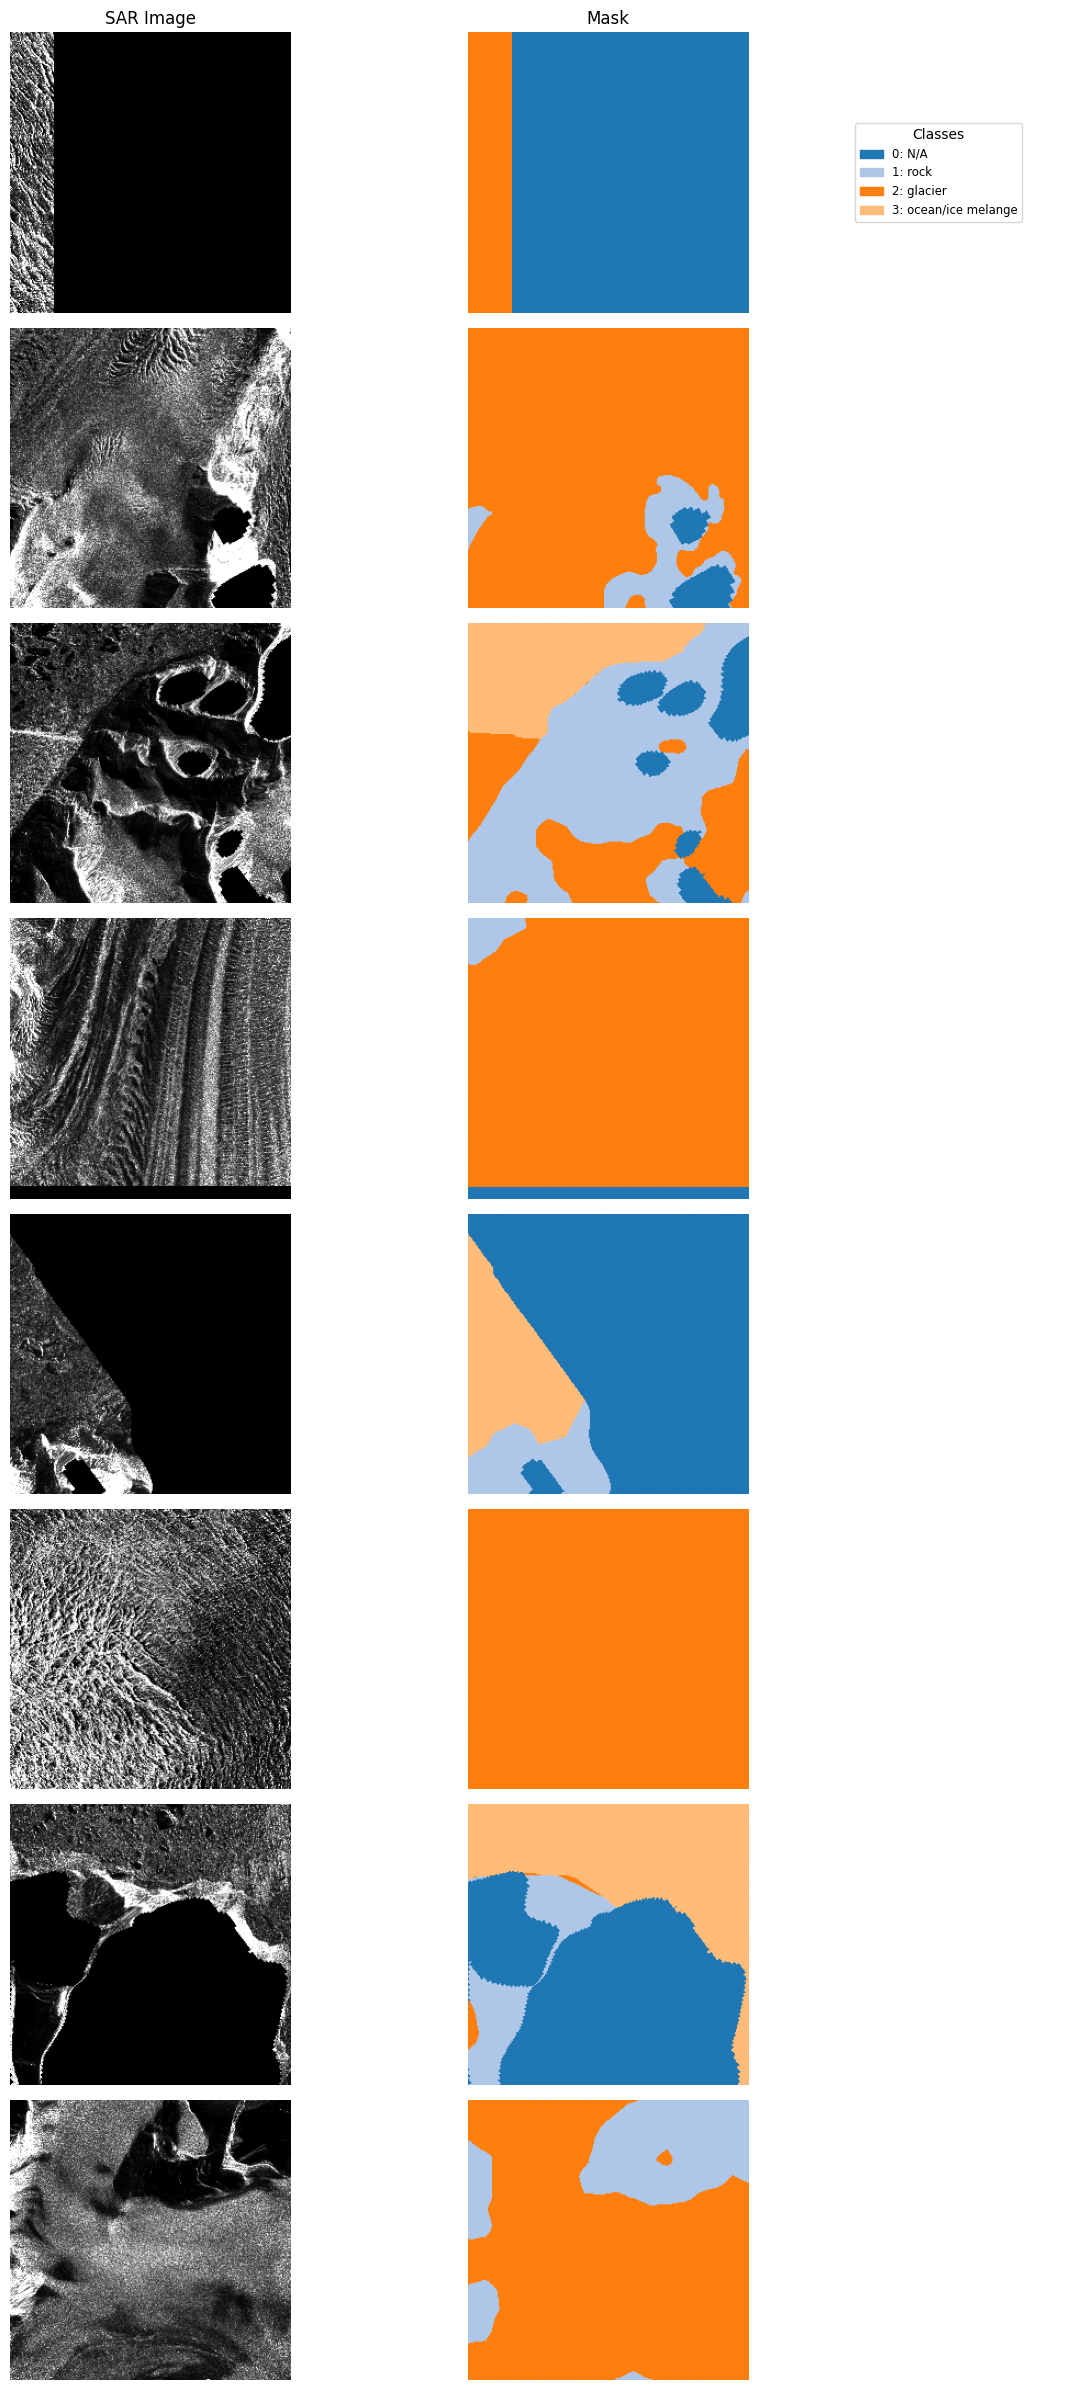

In [15]:
fig, batch = datamodule.visualize_batch()